In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mstats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import joblib

In [4]:
# load the train & test datasets
train_df = pd.read_csv("/content/drive/MyDrive/projects/abalone_age_prediction/data/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/projects/abalone_age_prediction/data/test.csv")

# Exploratory Data Analysis (EDA)

In [5]:
# display the first few rows of the train dataset
display(train_df.head())

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [6]:
# display the first few rows of the test dataset
display(test_df.head())

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [7]:
# shape of train data
print(train_df.shape)

(90615, 10)


In [8]:
# shape of test data
print(test_df.shape)

(60411, 9)


In [9]:
# display the structure of the training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


**Observation:**
* All columns have 90615 non-null entries, indicating there are no missing values in any column.
* The `Sex` column is of type `object`, which typically represents categorical data.
* The other columns are numerical, with `float64` and `int64` data types. Specifically, 'id' & 'Rings' are integer types, while the rest are floating-point numbers.

In [10]:
# descriptive statistics for numerical features
print("Summary of the dataset:\n")
display(train_df.describe())

Summary of the dataset:



,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


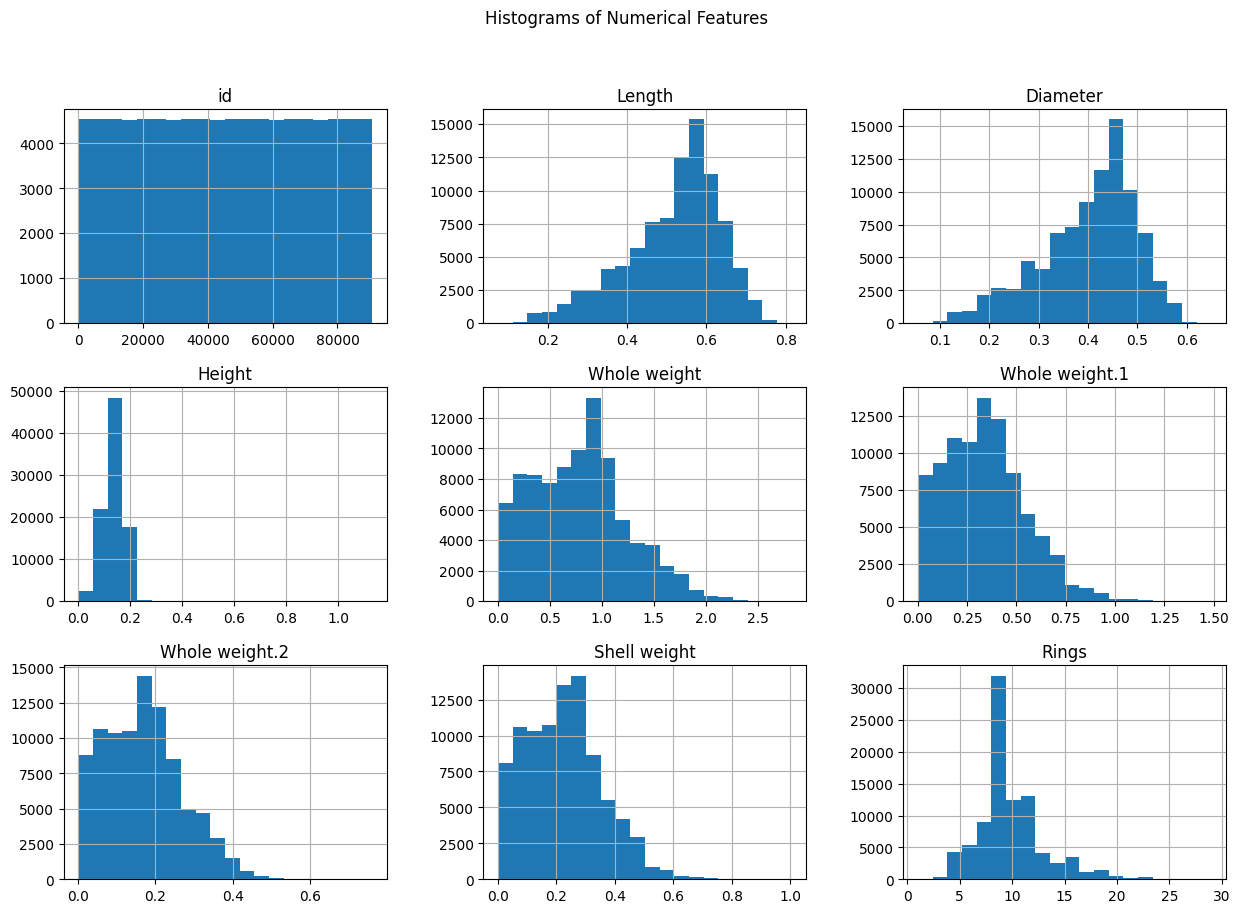

In [11]:
# Histograms for numerical features
train_df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

**Observations:**

1. Length: The distribution of Length is slightly right-skewed, with a peak around 0.55. There are fewer abalones with very small or very large lengths.

2. Diameter: Similar to Length, the Diameter distribution is right-skewed, peaking around 0.4. The pattern indicates that most abalones have diameters in the middle range, with fewer at the extremes.

3. Height: The distribution of Height is also right-skewed, with a peak around 0.15. There are fewer abalones with very small or very large heights.

4. Whole_weight: The Whole_weight distribution is right-skewed, peaking around 1.0. There are fewer abalones with very low or very high weights, indicating that most abalones are of moderate weight.

5. Shucked_weight: The Shucked_weight distribution is right-skewed, with a peak around 0.3. This suggests that the majority of abalones have moderate meat weights after shucking.

6. Viscera_weight: The Viscera_weight distribution is right-skewed, peaking around 0.2. This indicates that most abalones have moderate viscera weights, with fewer abalones having very low or very high viscera weights.

7. Shell_weight: The Shell_weight distribution is right-skewed, peaking around 0.25. Most abalones have moderate shell weights, with fewer at the extreme ends.

8. Rings (Target Variable): The distribution of Rings (used as a proxy for age) is multi-modal and slightly right-skewed, peaking around 10. This suggests that most abalones in the dataset have around 10 rings, with fewer abalones having very low or very high ring counts.

Hence

**Skewness:** Most of the features are right-skewed, indicating that there are more abalones with moderate measurements and fewer with extreme measurements.

**Spread:** The data for each feature is spread out across a range of values, but the majority of the data points lie within a central region.

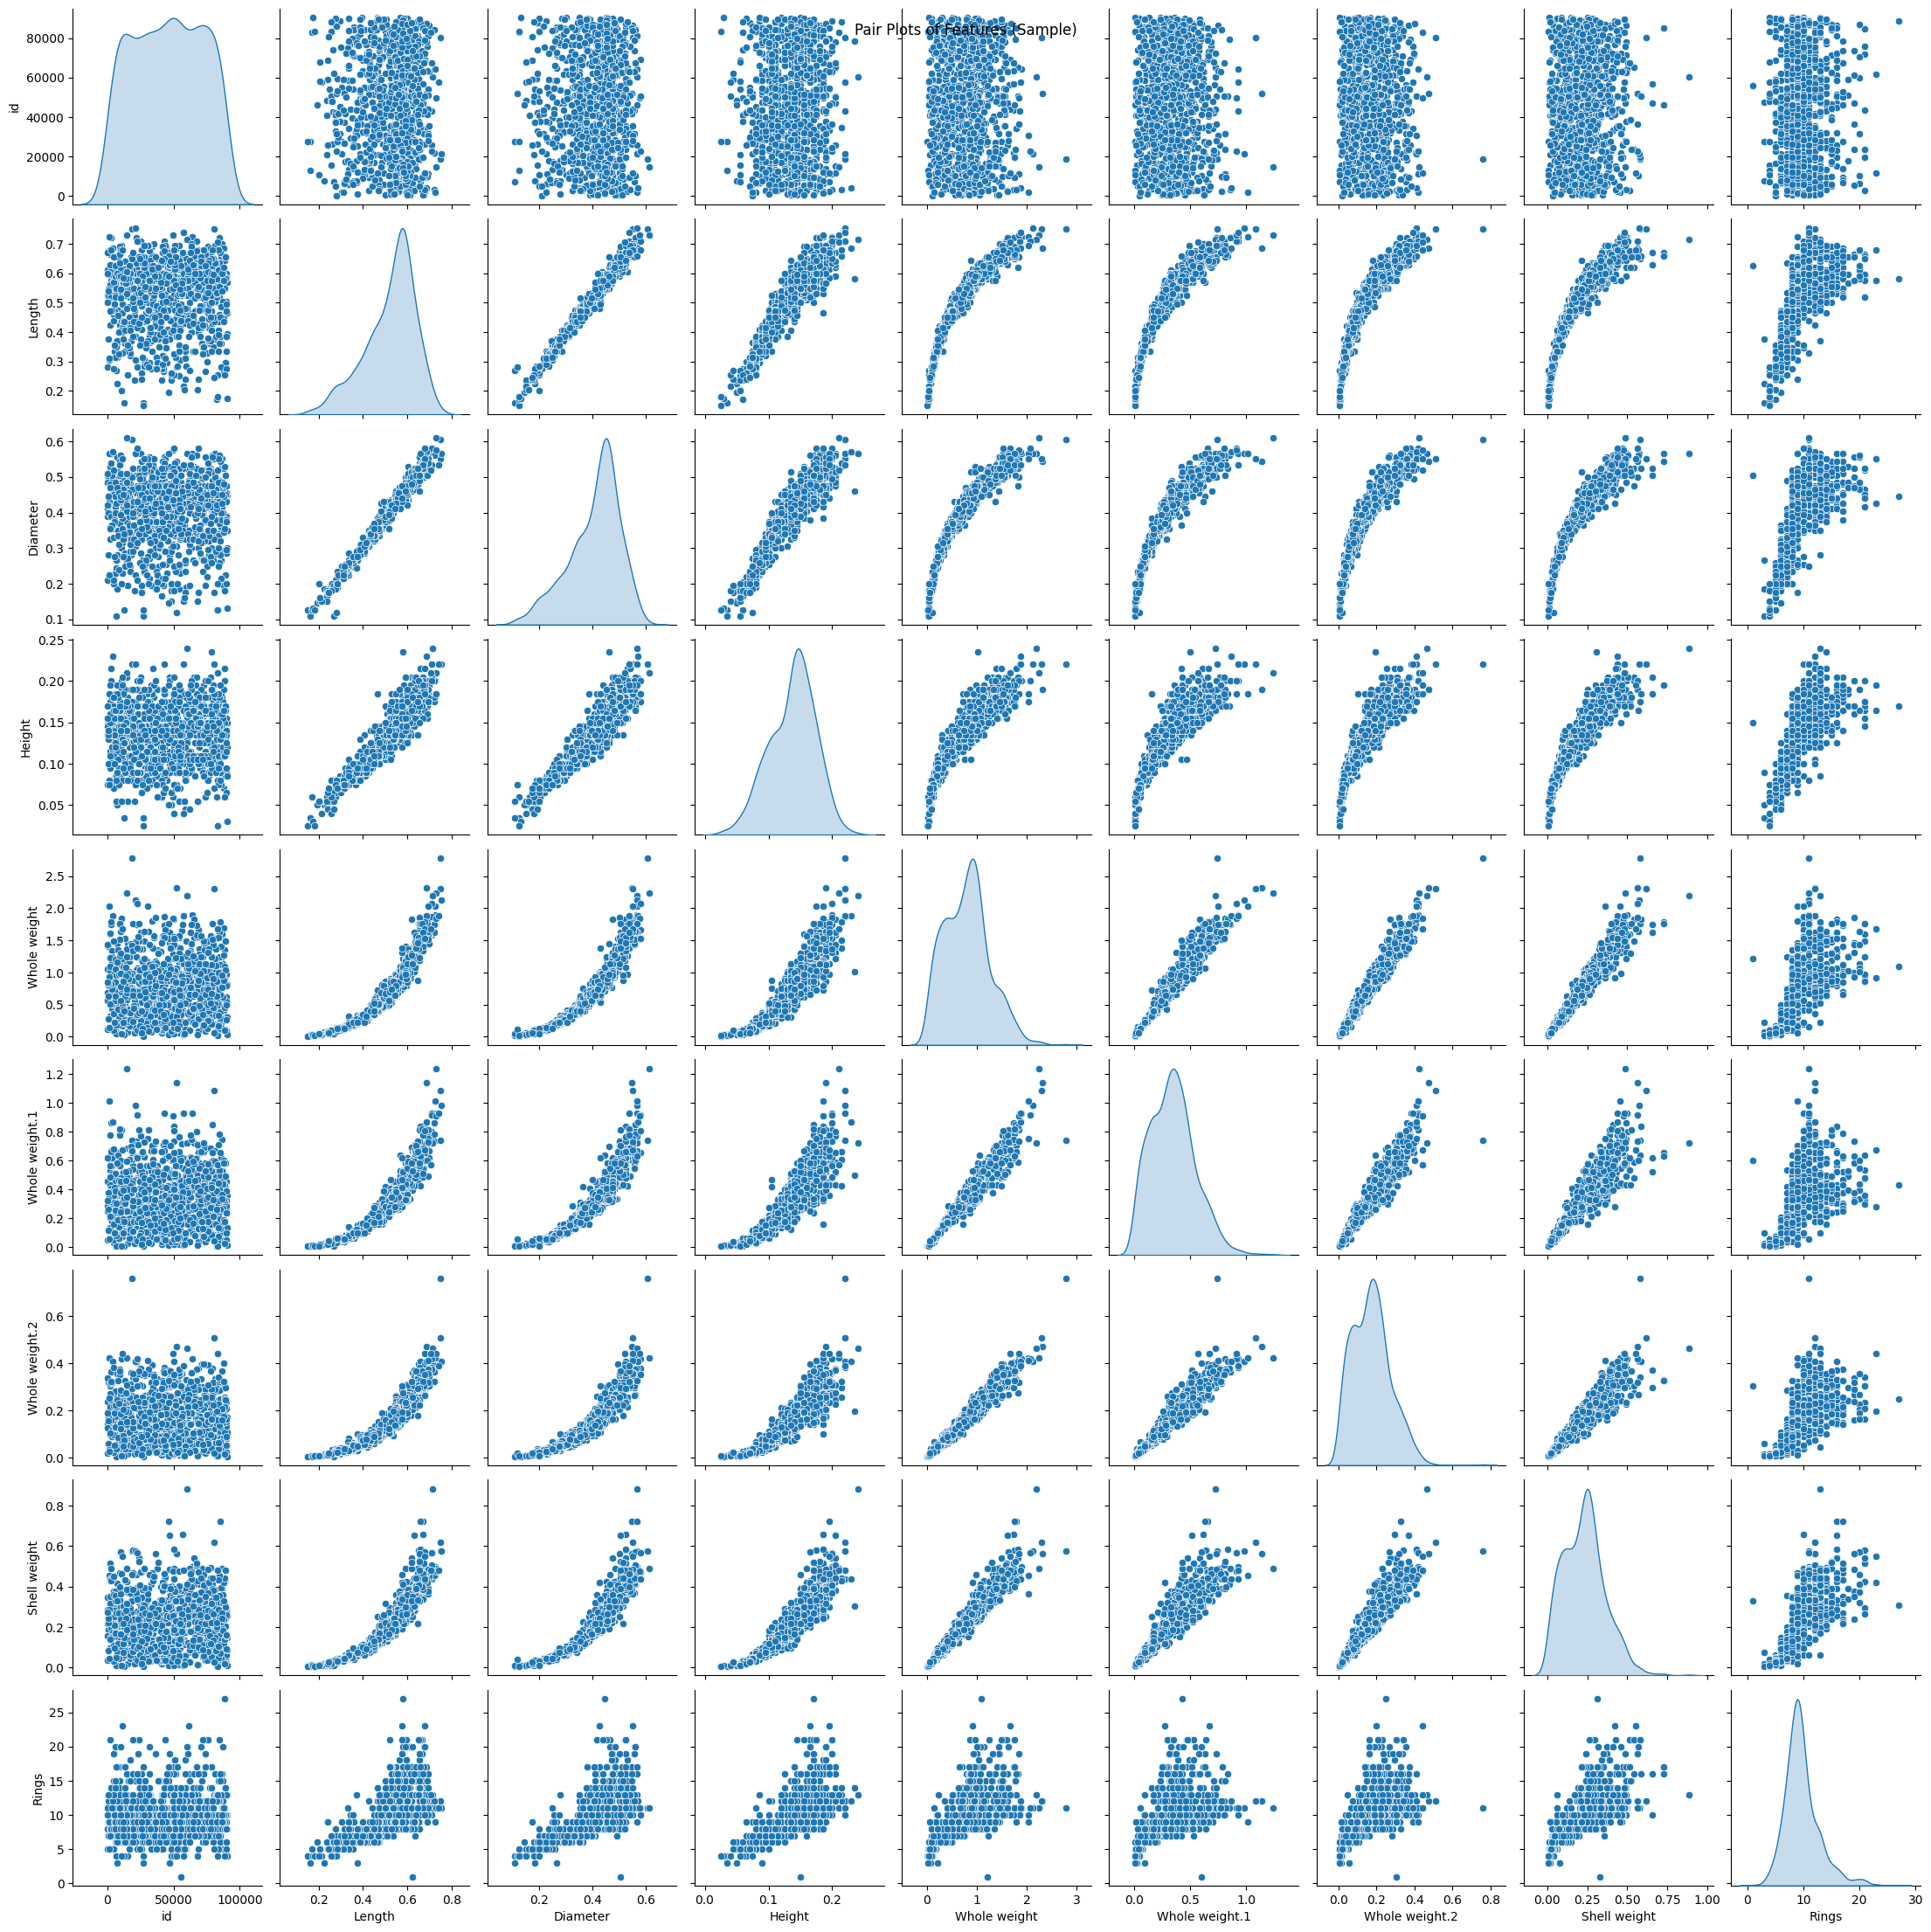

In [12]:
# Pair plots to visualize relationships between features
sns.pairplot(train_df.sample(1000), diag_kind='kde')
plt.suptitle('Pair Plots of Features (Sample)')
plt.show()

**Observations:**

1. Length, Diameter, Height:
  * **Positive Correlations:** Length, Diameter, and Height are positively correlated with each other. This is evident from the upward sloping scatter plots. Larger abalones tend to have greater length, diameter, and height.
  * **Distribution Shapes:** The diagonal plots show that these features are right-skewed, with more data points concentrated towards the higher values.

2. Whole_weight, Shucked_weight, Viscera_weight, Shell_weight:
  * **Positive Correlations:** These weight-related features are strongly positively correlated with each other. Abalones with higher whole weights tend to have higher shucked, viscera, and shell weights.
  * **Distribution Shapes:** The diagonal plots show right-skewed distributions for these features as well, with more data points concentrated towards the higher values.

3. Rings (Target Variable):
  * **Correlations with Length, Diameter, Height, and Weights:** Rings show a moderate positive correlation with Length, Diameter, Height, Whole_weight, Shucked_weight, Viscera_weight, and Shell_weight. This indicates that older abalones (more rings) tend to be larger and heavier.
  * **Distinct Steps:** The scatter plots with Rings on the y-axis show distinct steps or bands. This pattern is due to the discrete nature of the Rings feature, which is an integer count of the number of rings.

**Key Insights:**

**1. Strong Positive Correlations:** The features related to size (Length, Diameter, Height) and weight (Whole_weight, Shucked_weight, Viscera_weight, Shell_weight) are all positively correlated with each other. This suggests that larger abalones tend to be heavier.

**2. Moderate Correlation with Target:** The target variable Rings has a moderate positive correlation with the size and weight features, indicating that older abalones tend to be larger and heavier.

**3. Right-Skewed Distributions:** Most of the features exhibit right-skewed distributions, suggesting the presence of a few very large/heavy abalones.

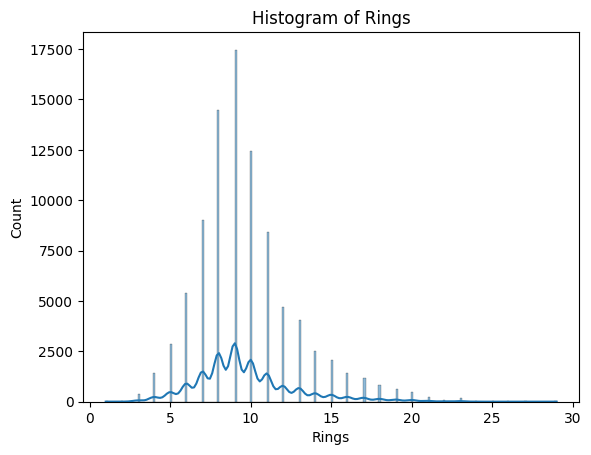

In [13]:
# Target variable distribution
sns.histplot(train_df['Rings'], kde=True)
plt.title('Histogram of Rings')
plt.show()

**Observations:**

1. Distribution Shape:
  * The histogram shows a slightly right-skewed distribution.
  * The majority of the abalone have ring counts between 7 and 11, with a peak at around 9 rings.

2. Peaks and Modes:
  * There are distinct peaks at certain ring counts, particularly at 10 rings.
  * These peaks suggest that certain age groups (represented by ring counts) are more common in the dataset.

3. Range and Spread:
  * The ring counts range from 4 to 20.
  * There are fewer abalone with very low or very high ring counts, indicating that extreme ages are less common.

4. KDE Line:
  * The kernel density estimate (KDE) line overlays the histogram, providing a smoothed estimate of the distribution.
  * The KDE line shows multiple small peaks and valleys, reflecting the multi-modal nature of the distribution.

'Correlation Matrix:'

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,1.000000,0.004724,0.004290,0.005916,0.005228,0.004203,0.004878,0.005887,0.000938
Length,0.004724,1.000000,0.989732,0.916094,0.931449,0.909609,0.913134,0.911073,0.623786
Diameter,0.004290,0.989732,1.000000,0.919618,0.933848,0.908466,0.914668,0.917871,0.636832
Height,0.005916,0.916094,0.919618,1.000000,0.902344,0.861769,0.886132,0.904019,0.665772
Whole weight,0.005228,0.931449,0.933848,0.902344,1.000000,0.971249,0.974319,0.964201,0.617274
Whole weight.1,0.004203,0.909609,0.908466,0.861769,0.971249,1.000000,0.949227,0.911800,0.515067
Whole weight.2,0.004878,0.913134,0.914668,0.886132,0.974319,0.949227,1.000000,0.937069,0.588954
Shell weight,0.005887,0.911073,0.917871,0.904019,0.964201,0.911800,0.937069,1.000000,0.694766
Rings,0.000938,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,1.000000


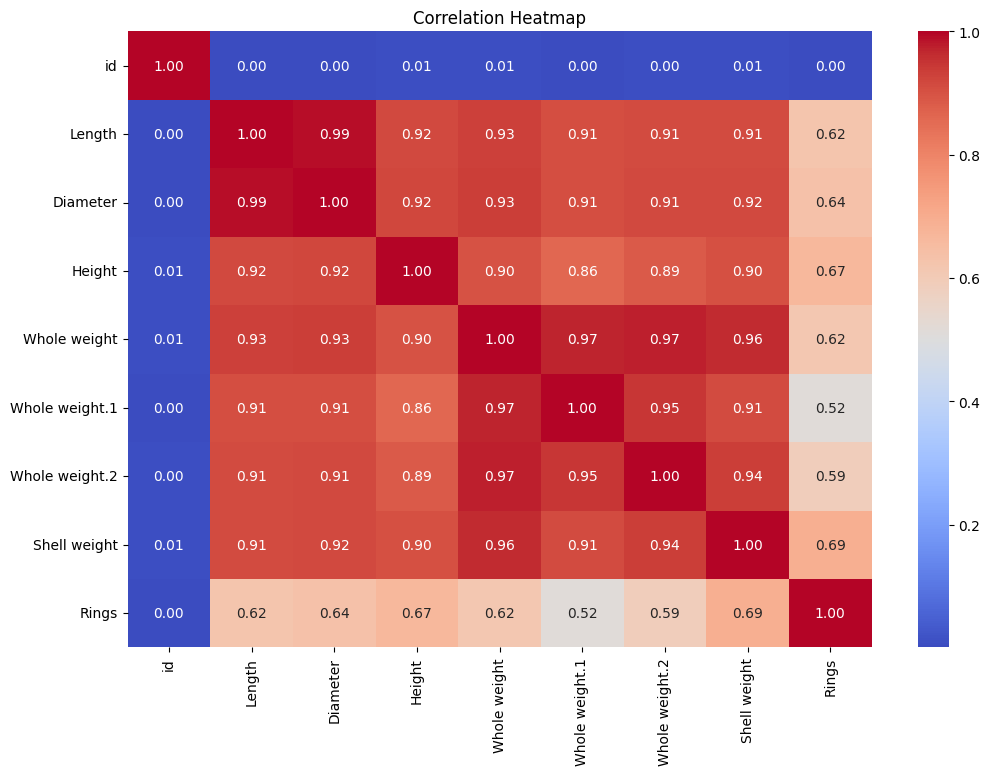

In [14]:
# Compute the correlation matrix
corr_matrix = train_df[train_df.select_dtypes(include=[np.number]).columns].corr()

# Display the correlation matrix
display("Correlation Matrix:", corr_matrix)

# Heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Observations:**

1. Length, Diameter, Height:
  * **High Correlation with Each Other:** Length, Diameter, and Height have very high correlations with each other (e.g., Length-Diameter: 0.990, Length-Height: 0.929). This indicates that these features are highly interrelated, suggesting that as one dimension of the abalone increases, so do the others.

2. Whole_weight, Shucked_weight, Viscera_weight, Shell_weight:
  * **High Correlation with Each Other:** These weight-related features have very high correlations with each other (e.g., Whole_weight-Shucked_weight: 0.973, Whole_weight-Viscera_weight: 0.976). This suggests that heavier abalones tend to have proportionally heavier components.

3. Rings (Target Variable):
  * **Moderate to High Correlation with Other Features:** Rings has moderate to high correlations with all other features, indicating that larger and heavier abalones tend to have more rings (e.g., Rings-Shell_weight: 0.706, Rings-Height: 0.685). This is expected since larger abalones are generally older and have more rings.

**Key Insights:**

**1. Multicollinearity:** The high correlations among Length, Diameter, and Height, and among weight-related features, suggest multicollinearity. In models like linear regression, multicollinearity can cause issues. However, tree-based models (e.g., Random Forests) are less sensitive to multicollinearity.

**2. Feature Selection:** While tree-based models can handle multicollinearity, it's still beneficial to consider feature importance during model training. In linear models, it may be necessary to reduce multicollinearity by combining or removing highly correlated features.

**3. Predictive Power:** The moderate to high correlations between Rings and other features indicate that these features are good predictors for the target variable. This justifies their inclusion in the predictive modeling process.

# Data Preprocessing

## 1. Data Cleaning

In [15]:
# check for duplicate rows in the training dataset
display(train_df.duplicated().sum())

0

**Observation:**

There are no duplicate rows in the training dataset.

In [16]:
# rename columns in both train & test data
train_df.rename({"Whole weight":"Whole_weight",
                 "Whole weight.1":"Shucked_weight",
                 "Whole weight.2":"Viscera_weight",
                 "Shell weight":"Shell_weight"}, axis=1, inplace=True)

test_df.rename({"Whole weight":"Whole_weight",
                "Whole weight.1":"Shucked_weight",
                "Whole weight.2":"Viscera_weight",
                "Shell weight":"Shell_weight"}, axis=1, inplace=True)

In [17]:
# drop "id" column from train & test dataframe
train_df.drop(columns=["id"], axis=1, inplace=True)
test_df.drop(columns=["id"], axis=1, inplace=True)

In [18]:
display(train_df.head())

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [19]:
# identify outliers using the IQR method
# select numerical columns for outlier detection
numerical_cols = train_df.select_dtypes(include=[np.number]).columns

# calculate Q1 (25th percentile) and Q3 (75th percentile) for each numerical column
Q1 = train_df[numerical_cols].quantile(0.25)
Q3 = train_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# define outliers as points outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
outliers_IQR = ((train_df[numerical_cols] < (Q1 - 1.5*IQR)) | (train_df[numerical_cols] > (Q3 + 1.5*IQR))).any(axis=1)
outliers_IQR_count = outliers_IQR.sum()

# Display the number of detected outliers using the IQR method
display(outliers_IQR_count)

8457

In [20]:
# check skewness of the numerical columns
# calculate skewness for numerical columns
skewness = train_df[numerical_cols].skew()
print("Skewness of numerical columns: \n", skewness)

Skewness of numerical columns: 
 Length           -0.732015
Diameter         -0.695236
Height            0.309975
Whole_weight      0.429316
Shucked_weight    0.591973
Viscera_weight    0.476733
Shell_weight      0.479092
Rings             1.204273
dtype: float64


**Observations:**

* Based on the skewness values:
  * Length: Moderately left-skewed (-0.900061)
  * Diameter: Moderately left-skewed (-0.845983)
  * Height: Approximately symmetric (-0.338422)
  * Whole_weight: Approximately symmetric (-0.141274)
  * Shucked_weight: Approximately symmetric (0.153496)
  * Viscera_weight: Approximately symmetric (0.237680)
  * Shell_weight: Approximately symmetric (0.148613)
  * Rings: Approximately symmetric (0.067803)

* None of the features exhibit high positive skewness (all are within the range of approximately symmetric to moderately skewed). Therefore, log transformation is not necessary for this dataset.

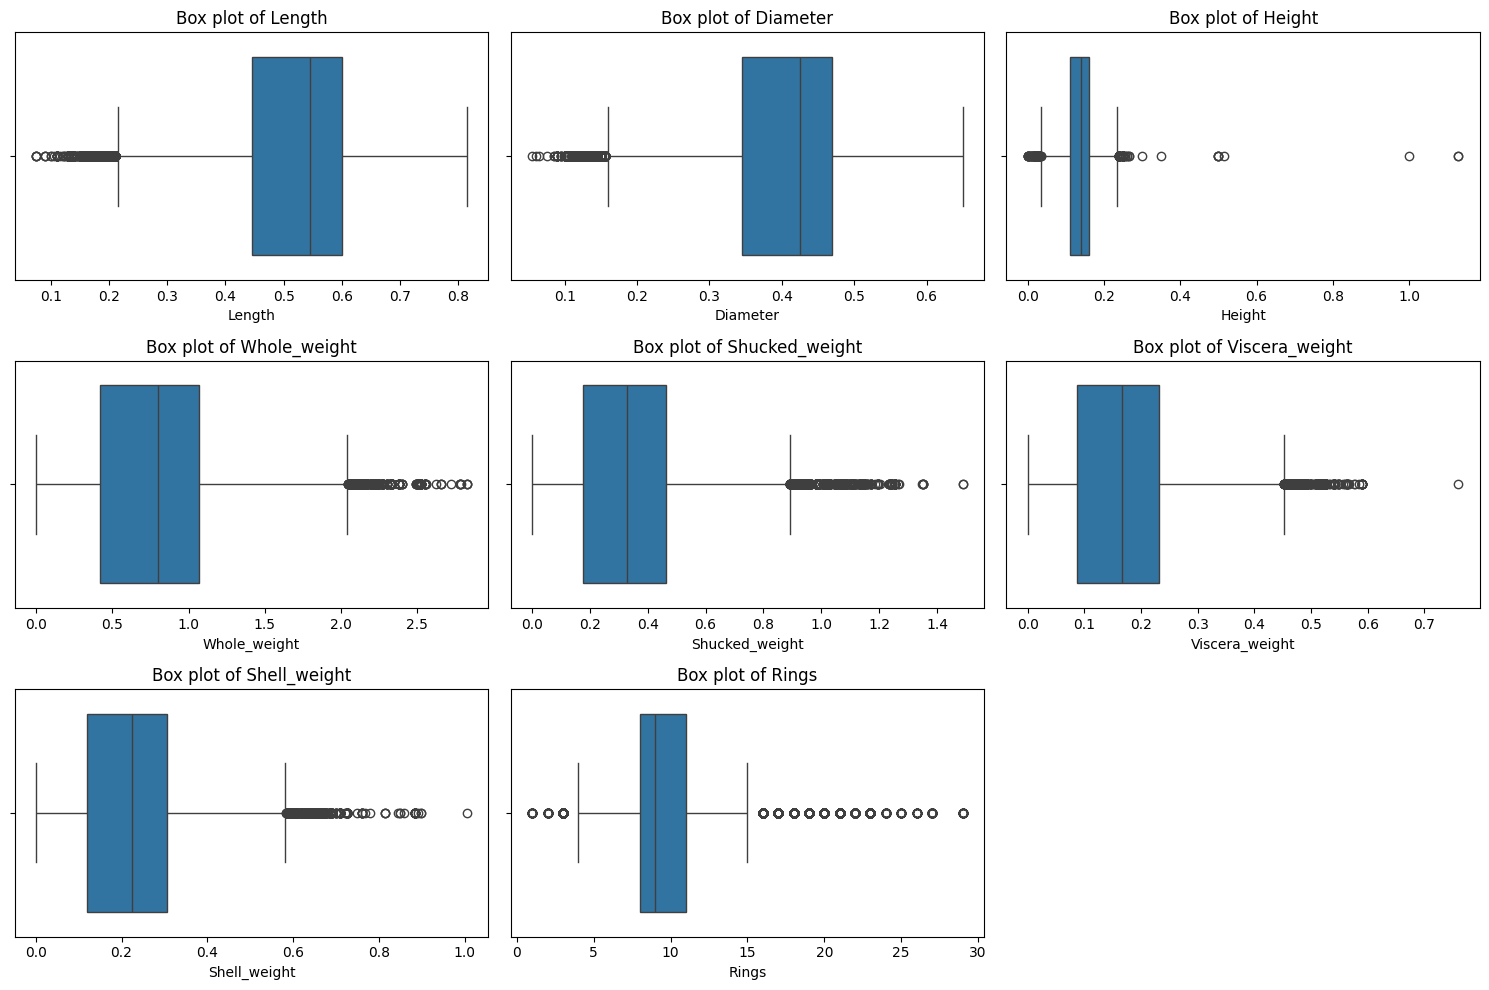

In [21]:
# visualize the outliers using box plots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
  plt.subplot(3, 3, i+1)
  sns.boxplot(x=train_df[col])
  plt.title(f"Box plot of {col}")
plt.tight_layout()
plt.show()

**Observation:**

All the features show the presence of outliers. Several features have significant outliers.
1. Length, Diameter, Height: Outliers are present, primarily on the lower end for Length and Diameter, and both ends for Height.
2. Whole_weight, Shucked_weight, Viscera_weight, Shell_weight: There are outliers primarily on the higher end for these weight-related features.
3. Rings: There are outliers on both ends, particularly higher values.

* We can use Winsorization, to cap the extreme values at specified percentiles, so that the impact of extreme values can be reduced without removing them completely.

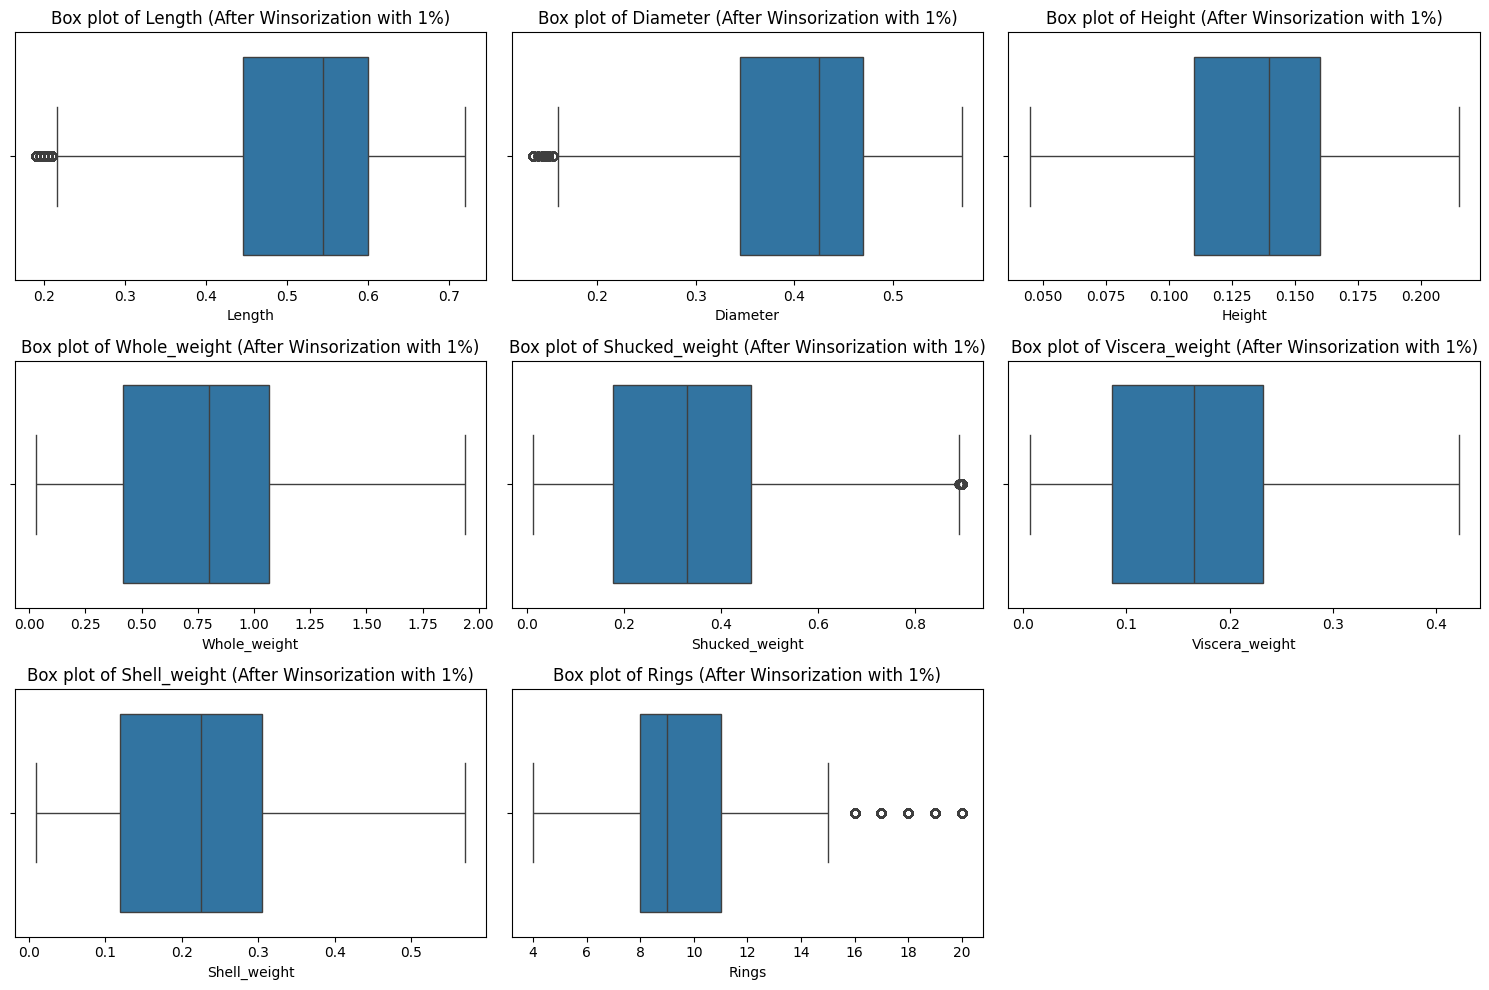

In [22]:
# apply Winsorization to numerical columns
for col in numerical_cols:
  train_df[col] = mstats.winsorize(train_df[col], limits=[0.01, 0.01])

# visualize the transformed features again using box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
  plt.subplot(3, 3, i+1)
  sns.boxplot(x=train_df[col])
  plt.title(f"Box plot of {col} (After Winsorization with 1%)")
plt.tight_layout()
plt.show()

**Observations:**

* The box plots generated after applying Winsorization with a 1% limit show a significant reduction in the number of extreme outliers.
  1. Length, Diameter, Height: Winsorization has effectively reduced the impact of extreme values. These features now have a more concentrated range without extreme outliers.
  2. Whole Weight, Shucked Weight, Viscera Weight, Shell Weight: The distributions of these weight-related features have been regularized, with most extreme values capped.
  3. Rings: The target variable has also been winsorized, with only a few outliers remaining, which are within an acceptable range.

* As we will be using Tree-based model (Random Forest), even though there are few outliers remaining, we can proceed to our next steps of model creation.

In [23]:
# numerical columns in test data
numerical_cols_test = test_df.select_dtypes(include=[np.number]).columns

# Apply Winsorization to numerical columns in the test data with the same limits
for col in numerical_cols_test:
    test_df[col] = mstats.winsorize(test_df[col], limits=[0.01, 0.01])

# Check the results
print(test_df.head())

  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.645     0.475   0.155        1.2380          0.6185          0.3125   
1   M   0.580     0.460   0.160        0.9830          0.4785          0.2195   
2   M   0.560     0.420   0.140        0.8395          0.3525          0.1845   
3   M   0.570     0.490   0.145        0.8740          0.3525          0.1865   
4   I   0.415     0.325   0.110        0.3580          0.1575          0.0670   

   Shell_weight  
0        0.3005  
1        0.2750  
2        0.2405  
3        0.2350  
4        0.1050  


## 2. Data Splitting

In [24]:
# Separate features and target variable from the training data
X = train_df.drop(columns=['Rings'])
y = train_df['Rings']

In [25]:
# Split the data into training (70%) and validation sets (30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

## 3. Data Transformation

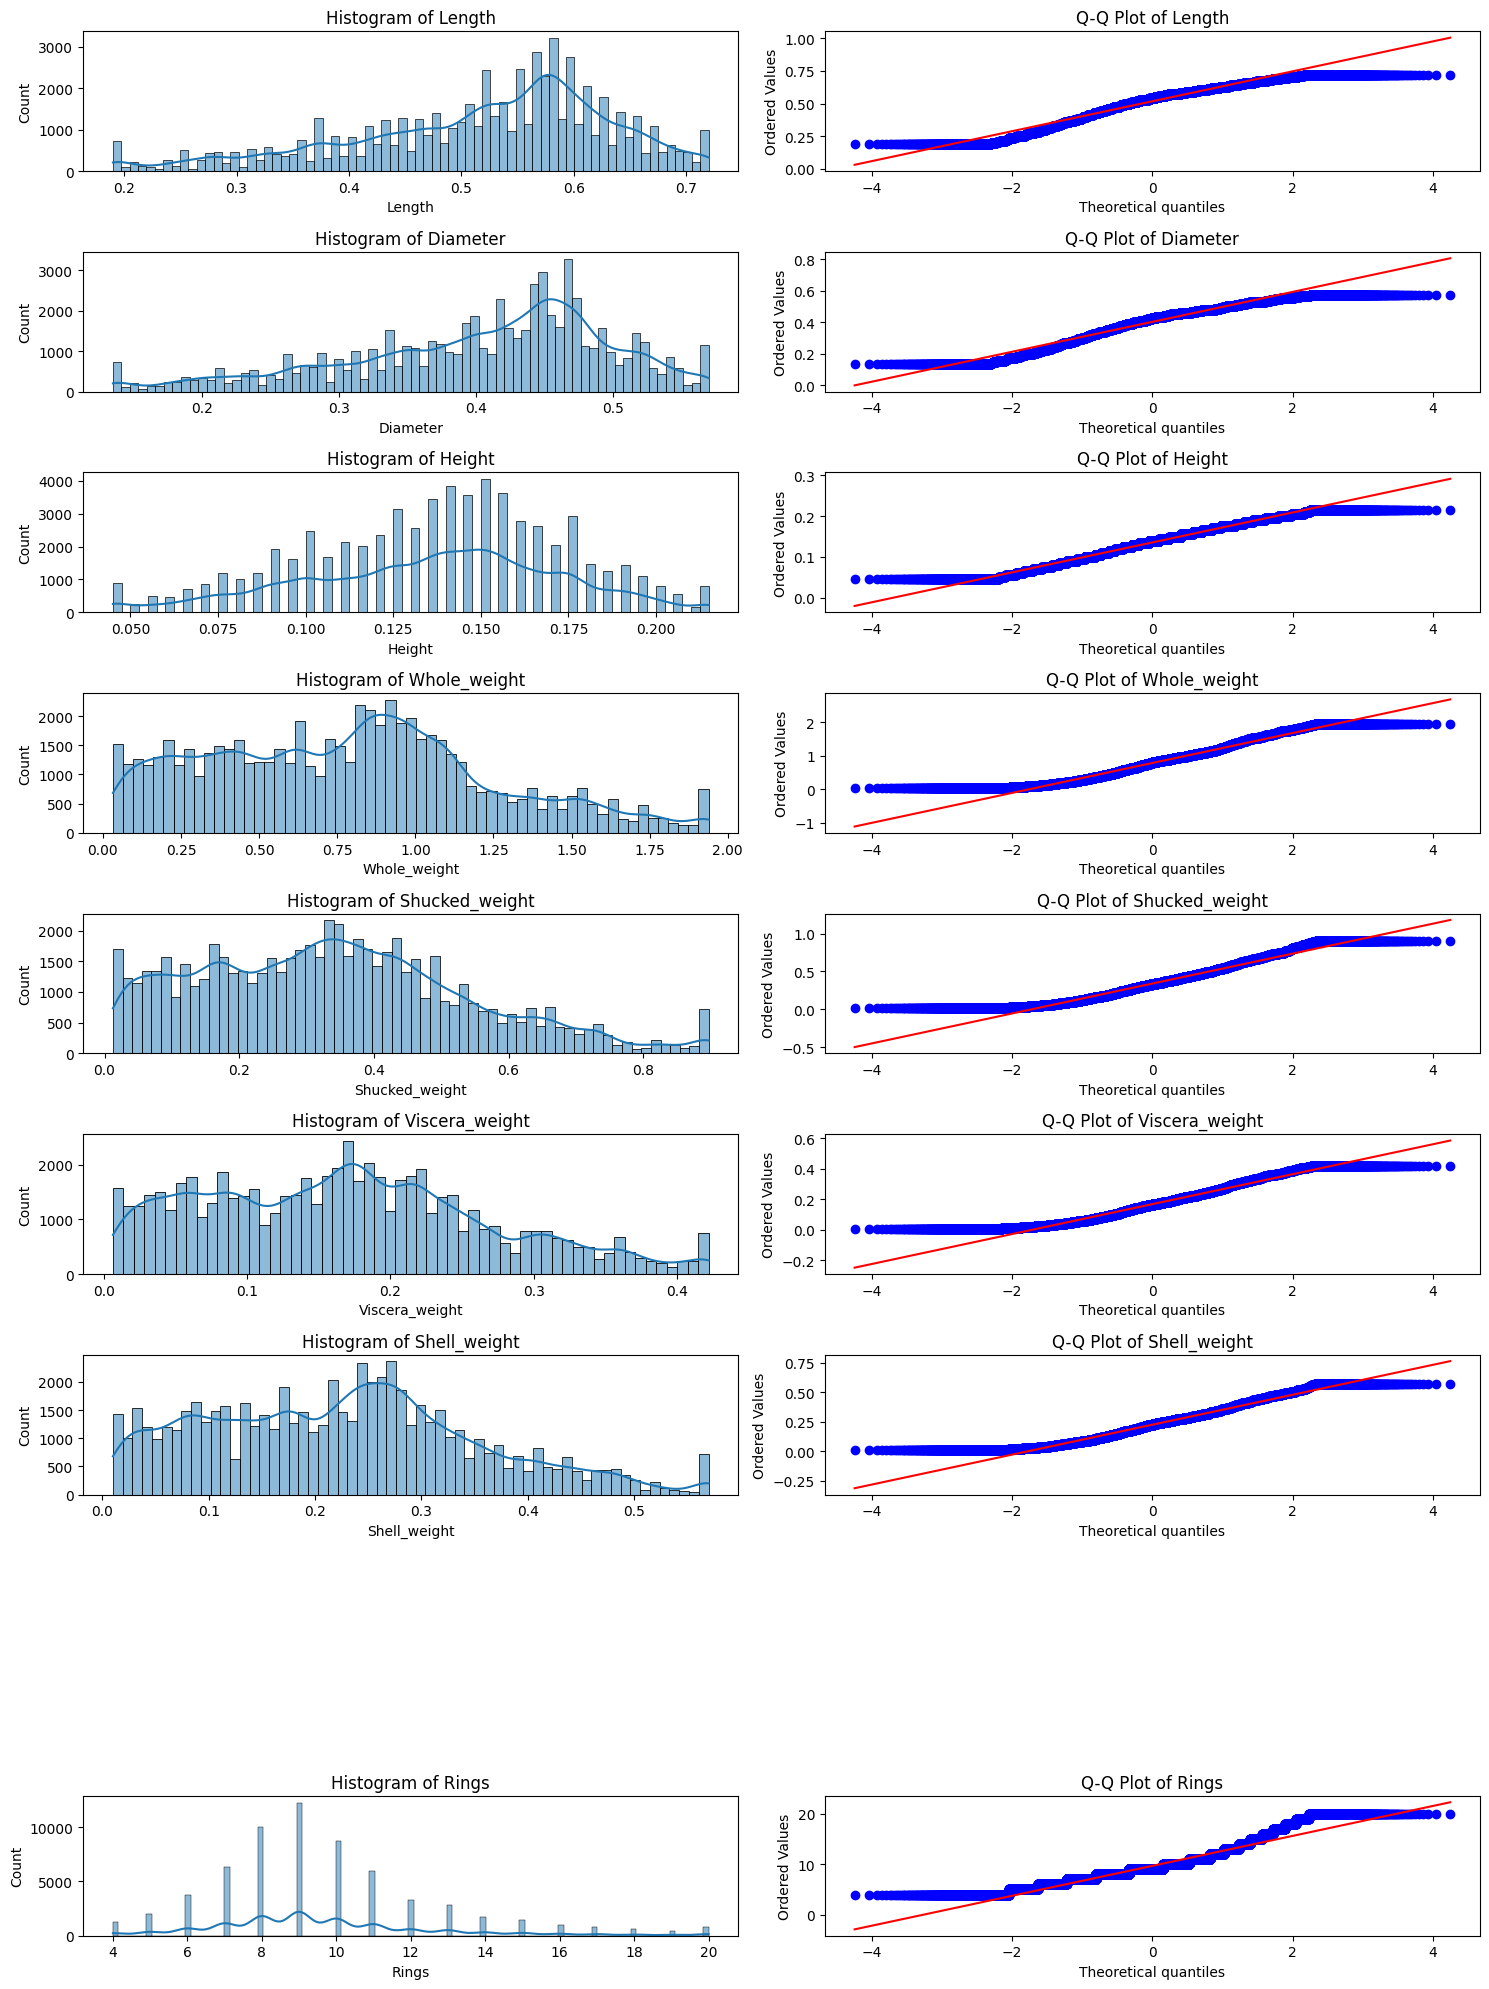

In [26]:
# checking the data distribution visually

# Define numerical columns
num_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# plot histograms and Q-Q plots for numerical columns
plt.figure(figsize=(15, 20))
num_plots = len(numerical_cols) + 1  # Additional plot for the target variable

for i, col in enumerate(num_cols):
    plt.subplot(num_plots, 2, 2*i+1)
    sns.histplot(X_train[col], kde=True)
    plt.title(f"Histogram of {col}")

    plt.subplot(num_plots, 2, 2*i+2)
    stats.probplot(X_train[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")

# Plot histogram and Q-Q plot for the target variable
plt.subplot(num_plots, 2, 2*num_plots-1)
sns.histplot(y_train, kde=True)
plt.title(f"Histogram of Rings")

plt.subplot(num_plots, 2, 2*num_plots)
stats.probplot(y_train, dist="norm", plot=plt)
plt.title(f"Q-Q Plot of Rings")

plt.tight_layout()
plt.show()

**Observations:**

1. Length, Diameter, Height:
  * **Histograms:** These features show some degree of skewness, particularly Length and Diameter.
  * **Q-Q Plots:** The data points deviate from the diagonal line, indicating departures from normality, especially in the tails.

2. Whole_weight, Shucked_weight, Viscera_weight, Shell_weight:
  * **Histograms:** These distributions are relatively spread out and exhibit skewness.
  * **Q-Q Plots:** There is a noticeable deviation from the diagonal line, particularly in the tails, suggesting non-normality.

3. Rings (Target Variable):
  * **Histograms:** The distribution is somewhat multi-modal and does not follow a normal distribution.
  * **Q-Q Plot:** Significant deviations from the straight line, particularly in the tails, indicating non-normality.

Hence, the data does not perfectly follow a Gaussian distribution.

* As we will use Tree-based model, though it is not strictly necessary, but applying log transformation to highly skewed features can still help in stabilizing variance and reducing the skewness and stabilizing variance. This can sometimes lead to better performance and more stable models.

In [27]:
# Define the columns to log-transform
log_transform_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# Apply log transformation to features
for col in log_transform_cols:
    X_train[col] = np.log1p(X_train[col])
    X_val[col] = np.log1p(X_val[col])
    test_df[col] = np.log1p(test_df[col])

# Apply log transformation to the target variable
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [28]:
# encode categorical variable
# encode "Sex" column using one-hot encoding
encoder = OneHotEncoder(drop="first") # drop the first category to avoid multicollinearity
encoded_sex_train = encoder.fit_transform(X_train[['Sex']]).toarray()
encoded_sex_val = encoder.transform(X_val[['Sex']]).toarray()
encoded_sex_test = encoder.transform(test_df[['Sex']]).toarray()

In [29]:
# Convert encoded columns to DataFrame
encoded_sex_train_df = pd.DataFrame(encoded_sex_train, columns=encoder.get_feature_names_out(['Sex']))
encoded_sex_val_df = pd.DataFrame(encoded_sex_val, columns=encoder.get_feature_names_out(['Sex']))
encoded_sex_test_df = pd.DataFrame(encoded_sex_test, columns=encoder.get_feature_names_out(['Sex']))

In [30]:
# Drop the original 'Sex' column and concatenate the encoded columns
X_train = X_train.drop(columns=['Sex']).reset_index(drop=True)
X_val = X_val.drop(columns=['Sex']).reset_index(drop=True)
test_df = test_df.drop(columns=['Sex']).reset_index(drop=True)

X_train = pd.concat([X_train, encoded_sex_train_df], axis=1)
X_val = pd.concat([X_val, encoded_sex_val_df], axis=1)
test_df = pd.concat([test_df, encoded_sex_test_df], axis=1)

In [31]:
display(X_train.head())

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_I,Sex_M
0,0.454255,0.368109,0.152721,0.670134,0.347130,0.176471,0.242946,0.0,1.0
1,0.491643,0.412110,0.144100,0.776799,0.494391,0.209856,0.256965,0.0,0.0
2,0.479335,0.398776,0.173953,0.732608,0.416735,0.202533,0.257352,0.0,1.0
3,0.542324,0.451076,0.139762,0.670646,0.431782,0.179401,0.318454,0.0,0.0
4,0.451076,0.364643,0.117783,0.617615,0.308954,0.164242,0.223144,0.0,0.0


In [32]:
display(test_df.head())

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_I,Sex_M
0,0.497740,0.388658,0.144100,0.805583,0.481500,0.271934,0.262749,0.0,1.0
1,0.457425,0.378436,0.148420,0.684611,0.391028,0.198441,0.242946,0.0,1.0
2,0.444686,0.350657,0.131028,0.609494,0.301955,0.169321,0.215515,0.0,1.0
3,0.451076,0.398776,0.135405,0.628075,0.301955,0.171008,0.211071,0.0,1.0
4,0.347130,0.281412,0.104360,0.306013,0.146263,0.064851,0.099845,1.0,0.0


# Feature Engineering


## 1. New Feature Creation

In [33]:
# creating new features
X_train['Length_Diameter'] = X_train['Length'] * X_train['Diameter']
X_train['Whole_Shucked'] = X_train['Whole_weight'] * X_train['Shucked_weight']
X_val['Length_Diameter'] = X_val['Length'] * X_val['Diameter']
X_val['Whole_Shucked'] = X_val['Whole_weight'] * X_val['Shucked_weight']
test_df['Length_Diameter'] = test_df['Length'] * test_df['Diameter']
test_df['Whole_Shucked'] = test_df['Whole_weight'] * test_df['Shucked_weight']

## 2. Feature Scaling

In [34]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data
X_val_scaled = scaler.transform(X_val)

# Transform the test data
test_scaled = scaler.transform(test_df)

# Model Creation

In [38]:
# Initialize the baseline GradientBoostingRegressor with default hyperparameters
baseline_xgbr = XGBRegressor(random_state=42)

In [39]:
# Train the baseline model
baseline_xgbr.fit(X_train_scaled, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Model Evaluation

In [41]:
# Evaluate the baseline model on the training set
y_train_pred_log_baseline = baseline_xgbr.predict(X_train_scaled)
y_train_pred_baseline = np.expm1(y_train_pred_log_baseline)
train_rmsle_baseline = np.sqrt(mean_squared_log_error(y_train, y_train_pred_baseline))
train_r2_baseline = r2_score(y_train, y_train_pred_baseline)
print(f"Baseline Training RMSLE: {train_rmsle_baseline}")
print(f"Baseline Training R^2: {train_r2_baseline}")

Baseline Training RMSLE: 0.12691474613193182
Baseline Training R^2: 0.7530640957783585


In [42]:
# Evaluate the baseline model on the validation set
y_val_pred_log_baseline = baseline_xgbr.predict(X_val_scaled)
y_val_pred_baseline = np.expm1(y_val_pred_log_baseline)
val_rmsle_baseline = np.sqrt(mean_squared_log_error(y_val, y_val_pred_baseline))
val_r2_baseline = r2_score(y_val, y_val_pred_baseline)
print(f"Baseline Validation RMSLE: {val_rmsle_baseline}")
print(f"Baseline Validation R^2: {val_r2_baseline}")

Baseline Validation RMSLE: 0.14445037184000367
Baseline Validation R^2: 0.6682821259130218


# Model Tuning

In [43]:
# Model Training with Gradient Boosting Regressor
xgb_reg = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [1, 1.5, 2, 2.5]
}
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_log_error',
                           n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train_log)

Fitting 5 folds for each of 27648 candidates, totalling 138240 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.3, 0.5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0, 0.1, 0.3, 0.5],
                         'reg_lambda': [1, 1.5, 2, 2.5],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_log_error', verbose=1)

In [50]:
# Best Model
best_xgbr = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 2.5, 'subsample': 0.8}


In [51]:
# Evaluate the model on the train set
y_train_pred_log = best_xgbr.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
print(f"Training RMSLE: {train_rmsle}")
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training R^2: {train_r2}")

Training RMSLE: 0.13122364112666254
Training R^2: 0.7293641602780039


These values indicate that the model fits the training data fairly well. The RMSLE of 0.1312 suggests that the model's predictions are close to the true values on the training set. An R² score of 0.7293 implies that approximately 72.93% of the variance in the target variable (Rings) is explained by the model on the training set.

In [52]:
# Evaluate the model on the validation set
y_val_pred_log = best_xgbr.predict(X_val_scaled)
y_val_pred = np.expm1(y_val_pred_log)
val_rmsle = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
print(f"Validation RMSLE: {val_rmsle}")
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation R^2: {val_r2}")

Validation RMSLE: 0.14278872498369002
Validation R^2: 0.6766704648488205


The validation RMSLE of 0.1427 is slightly higher than the training RMSLE, indicating some degree of model generalization with a minor increase in error on unseen data. An R² score of 0.6766 suggests that around 67.66% of the variance in the target variable is explained by the model on the validation set.

* The difference between the training RMSLE (0.1312) and the validation RMSLE (0.1427) is relatively small. This indicates that the model is not overfitting significantly and is generalizing well to unseen data.
* The R² scores for both training and validation sets are reasonably high, with the training set at 0.7293 and the validation set at 0.6766. While there is a slight drop in the R² score on the validation set, it is not substantial, further suggesting good model generalization.
* The model demonstrates a good fit on the training data and maintains robust performance on the validation data.
+ The small increase in RMSLE and slight decrease in R² from training to validation indicate that the model is not overfitting and generalizes well to unseen data.

In [53]:
# Final Predictions on Test Data
test_pred_log = best_xgbr.predict(test_scaled)
test_pred = np.expm1(test_pred_log)

In [48]:
# Prepare Submission
# submission = pd.DataFrame({'id': test_df['id'], 'Rings': test_pred})
# submission.to_csv('submission.csv', index=False)

In [55]:
# Save the best model
joblib_file = "best_xgb_model.pkl"
joblib.dump(best_xgbr, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to best_xgb_model.pkl
